# Solving a simple QUBO with QAOA

This section shows how QAOA can be used to solve a simple quadratic unconstrained binary optimisation (QUBO) problem. QUBOs have received significant interest in recent years as a way of tackling discrete combinatorial optimisation tasks, which are widespread in the logistics industry, amongst others. They have also attracted attention for their apparent amenability to implementation on near-term quantum hardware. For a good review of QUBOs and how to formulate them, see [Ref 1](#references).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyquil.paulis import PauliSum
from pyquil.api import WavefunctionSimulator
from pyquil.unitary_tools import lifted_pauli

from entropica_qaoa.qaoa.parameters import StandardParams
from entropica_qaoa.qaoa.cost_function import QAOACostFunctionOnWFSim

from scipy.optimize import minimize

## Defining the problem

Here we will tackle the simple problem given in Section 2 of [Ref 1](#references). We seek the minimum function value, and corresponding configuration of variables, of 

$$ y = -5x_1 -3x_2 -8x_3 -6x_4 + 4x_1x_2 + 8x_1x_3 + 2x_2x_3 + 10x_3x_4 $$

Here the variables $x_i$, $i = 1,...,4$ are binary. i.e. they can take the value 0 or 1. Observe that in the linear part (the first 4 terms), all of the variables would ideally be equal to 1 in order to minimise the function. However, the quadratic part (the second 4 terms) encodes penalties for having different pairs of variables equal to 1.

Note that in the linear part, we can simply square all of the variables, since $x_i = x_i^2$ for binary variables. We then transform the problem to minimisation of

$$
y^{\prime} = -5x_1^2 -3x_2^2 -8x_3^2 -6x_4^2 + 4x_1x_2 + 8x_1x_3 + 2x_2x_3 + 10x_3x_4 \\
= \left(\begin{matrix} x_4 & x_3 & x_2 & x_1\end{matrix}\right)
\left(\begin{matrix}
-6 & 5 & 0 & 0 \\
5 & -8 & 1 & 4 \\
0 & 1 & -3 & 2 \\
0 & 4 & 2 & -5
\end{matrix}
\right)
\left(\begin{matrix} x_4\\ x_3 \\ x_2 \\ x_1 \end{matrix}\right)
$$

We have ordered the variables in the binary strings such that $x_1$ appears as the least significant bit (i.e. on the right of the register), which corresponds to a common convention in the quantum computing community, and in particular for Rigetti's Pyquil: see __[here](http://docs.rigetti.com/en/stable/wavefunction_simulator.html#multi-qubit-basis-enumeration)__ for more information. Let's plot the function to see what the energy landscape looks like.

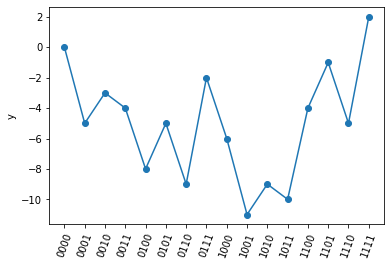

In [2]:
def func_y(config):
    
    matr = np.array([[-6, 5, 0, 0], [5, -8, 1, 4], [0, 1, -3, 2], [0, 4, 2, -5]])
    
    return config @ matr @ config

def num_2_bin(num):
    
    bin_str = np.binary_repr(num, width=4)
    bin_arr = np.array([int(x) for x in bin_str])
    
    return bin_arr

y_vals = [func_y(num_2_bin(i)) for i in range(16)]
bin_strings = ['{0:04b}'.format(i) for i in range(16)]

plt.plot(y_vals,'o-')
plt.xticks(range(16), bin_strings, rotation=70);
plt.ylabel('y')
plt.show()

The optimal solution is $x_1 = x_4 = 1$, $x_2 = x_3 = 0$, i.e. the bitstring 1001 (the binary representation of the number 9). Its corresponding function value is -11.

## Mapping to QAOA

To solve the problem using QAOA, we can associate the variable $x_i$ with the $i^{th}$ qubit of our quantum register. If the variable takes value 0, this corresponds to the qubit state being in state $|0\rangle$; likewise, the value 1 corresponds to the qubit being in state $|1\rangle$.

On a quantum computer we measure the state of a qubit in the $\{|0\rangle, |1\rangle\}$ basis by applying the $Z$ operator. However, the eigenvalues of this operator are $+1$ for the state $|0\rangle$, and $-1$ for the state $|1\rangle$. In order to map this to the 0,1 values of binary variables, we need to modify the measurement operator to be

$$ x_i \leftrightarrow \frac{\mathbb{I} - Z_i}{2} $$

where $\mathbb{I}$ is the identity operator.  With these considerations, the Hamiltonian $H_y$ encoding our objective function $y$ is:


$$
H_y = -\frac{1}{4}\left[5(\mathbb{I} - Z_1)^2 + 3(\mathbb{I} - Z_2)^2 + 8(\mathbb{I} - Z_3)^2 + 6(\mathbb{I} - Z_4)^2\right] \\ 
+ \frac{1}{4}\left[4(\mathbb{I} - Z_1)(\mathbb{I} - Z_2) + 8(\mathbb{I} - Z_1)(\mathbb{I} - Z_3) + 2(\mathbb{I} - Z_2)(\mathbb{I} - Z_3) + 10(\mathbb{I} - Z_3)(\mathbb{I} - Z_4)\right]
$$

Let's now set the problem up and proceed to solve it using QAOA.

In [2]:
# Linear part of the Hamiltonian
# For simplicity here we do not sqaure each term, as this does not affect the outcome
ham_lin = -0.5*PauliSum.from_compact_str('(-5)*Z1 + (-3)*Z2 + (-8)*Z3 + (-6)*Z4 + 22*I')

# Quadratic part of the Hamiltonian
ham_poly = 0.25*PauliSum.from_compact_str('4*Z1*Z2 + 4*I + (-4)*Z1 + (-4)*Z2 + 8*Z1*Z3 + 8*I + (-8)*Z1 + (-8)*Z3')
ham_poly += 0.25*PauliSum.from_compact_str('2*Z2*Z3 + 2*I + (-2)*Z2 + (-2)*Z3 + 10*Z3*Z4 + 10*I + (-10)*Z3 + (-10)*Z4')

ham = ham_lin + ham_poly

We can check that the eigenvalues of the Hamiltonian `ham` correspond to the function values we plotted above:

In [4]:
ham_matrix = lifted_pauli(ham, ham.get_qubits())
print('Eigenvalues: ', np.diag(ham_matrix)) # NB: ham is diagonal in the Z basis
print('')
print('Function values: ', y_vals)

Eigenvalues:  [  0.+0.j  -5.+0.j  -3.+0.j  -4.+0.j  -8.+0.j  -5.+0.j  -9.+0.j  -2.+0.j
  -6.+0.j -11.+0.j  -9.+0.j -10.+0.j  -4.+0.j  -1.+0.j  -5.+0.j   2.+0.j]

Function values:  [0, -5, -3, -4, -8, -5, -9, -2, -6, -11, -9, -10, -4, -1, -5, 2]


## Solution with `StandardParams`

Let's tackle the problem using the `StandardParams` parametrisation. We'll see how we do with $p=3$ timesteps, using Cobyla as our optimiser, and the `linear_ramp_from_hamiltonian` function to set up our inital parameters.

In [5]:
p = 3
standard_params = StandardParams.linear_ramp_from_hamiltonian(ham,p)

# Set up cost function and run optimisation
cost_std = QAOACostFunctionOnWFSim(ham,standard_params)
res_std = minimize(cost_std, standard_params.raw(), method = 'Cobyla')

# Print the output
res_std

     fun: -9.481743378102294
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 229
  status: 1
 success: True
       x: array([0.57705579, 0.36725195, 0.17168154, 0.13192841, 0.27705965,
       0.31679062])

The expectation value of the cost Hamiltonian `ham` is -9.48, however we know the true solution to have cost -11. Evidently, our QAOA circuit has not returned the correct solution, however we can examine the probability distribution of the output quantum state:

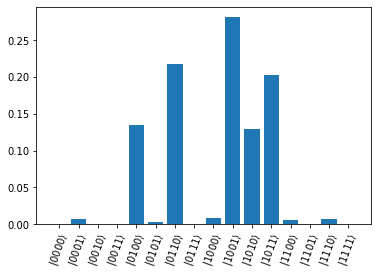

In [6]:
state = cost_std.get_wavefunction(res_std.x)
probs = state.probabilities()
labels = [r'$\left|{0:04b}\right>$'.format(i) for i in range(16)]
plt.bar(range(16),probs)
plt.xticks(range(16), labels, rotation=70);

Observe that the most probable state is $|1001\rangle$, which does indeed correspond to the minimum energy configuration of the variables. However, if we were to sample from a quantum computer, the above distribution would not allow us to conclude with high confidence that we have found the solution: there are several other bit strings with relatively high probabilities too.

Let's try increasing the parameter $p$ (the circuit depth) to see how more likely we are to obtain the optimal solution. To do this, we'll define a simple convenience function.

In [7]:
def state_prob_p(p):
    
    """
    Applies the QAOA circuit and returns the probability of measuring the bitstring 1001
    """
    
    params_std = StandardParams.linear_ramp_from_hamiltonian(ham,p)
    cost_std = QAOACostFunctionOnWFSim(ham,params_std)
    res_std = minimize(cost_std, params_std.raw(), method = 'Cobyla')
    state = cost_std.get_wavefunction(res_std.x)
    probs = state.probabilities()
    
    return probs[9] # The bitstring 1001 is the 9th entry of the vector of probabilities

We will run the above function for different values of $p$, and see how the probability of the optimal bistring 1001 increases.

In [8]:
# Running this cell should take 2 or 3 minutes.
p_vals = np.arange(1,13)
probability_opt_state = [state_prob_p(i) for i in p_vals]

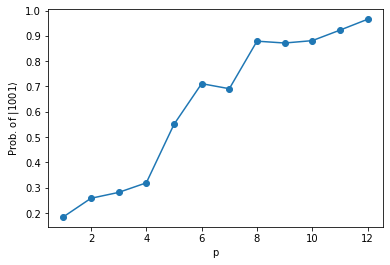

In [9]:
# Plot the probabilities
plt.plot(p_vals,probability_opt_state,'o-')
plt.xlabel('p')
plt.ylabel('Prob. of ' + r'$|1001\rangle$')
plt.show()

Clearly the optimal bit string probability approaches unity with increasing $p$.

<a id='references'></a>

## References

1. F. Glover et al, __[*A Tutorial on Formulating and Using QUBO Models*](https://arxiv.org/pdf/1811.11538.pdf)__.